## Notebook to read in brownian simulation output and animate the data
### WHATS UP WITH THE APERTURE ANGLES

#### Make sure markersize is equal to encounter radius 

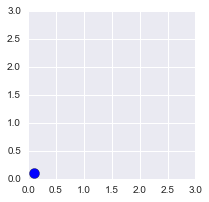

In [64]:
#fig = plt.figure(figsize=(3,3))
plt.scatter(r_enc,r_enc,s=100)
plt.xlim((0,L))
plt.ylim((0,H))
plt.savefig('/Users/jakehanson/Desktop/temp.pdf')
plt.show()

#### Create Animation

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Get Geometric Info
print 'GEOMETRY PARAMS--------------------------------------------------'
params = pd.read_csv('params.txt',sep='\t')
R = params.R[0]
a = params.a[0]
T = params.temp[0]
r_enc = params.r_enc[0]
N_ants = params.num_ants[0]
coll_flag = params.collision_flag[0]
print '\tBox Radius: ',R
print '\tAperture Size: ',a
print '\tNumber of Ants: ',N_ants
print '\tEncounter Radius: ',r_enc
print '\tTemperature: ',T
if coll_flag == 1:
    print '\tCollisions On.'
else:
    print '\tCollisions Off.'

## Get Simulation Info
print 'SIMULATION PARAMS------------------------------------------------'
data = pd.read_csv('output.txt',sep='\t')
uniq_time = np.unique(data.event_time)
t_max = uniq_time[-1]
t_min = uniq_time[1]-uniq_time[0]
for i in range(np.size(uniq_time)-1):
    delta_t = uniq_time[i+1] - uniq_time[i]
    if delta_t < t_min:
        t_min = delta_t
N_events = data.shape[0]/N_ants
print '\tNumber of Events: ',N_events
print '\tTotal Time: ',t_max
print '\tMinimum Time Between Events: ',t_min

## Animation Parameters
print 'ANIMATION PARAMS-------------------------------------------------'
N_frames = 500
output_every = 1
plot_dir = '/Users/jakehanson/Documents/Ants/plots/'
output_path = '/Users/jakehanson/Desktop/sim.gif'
# colors = sns.color_palette('deep',N_ants).as_hex()    # Colors only constant if ant number is fixed
#fig = plt.figure(figsize=(0,2*R))

## Init Disk
N_points = 100
x_disk = []
y_disk = []
theta_crit = a/R
## Init Disk of size (2*pi-theta_crit) starting at (pi/2+theta_rit/2)
for i in range(N_points+1):
    x = R*np.cos((np.pi+theta_crit)/2+(2*np.pi-theta_crit)*i/N_points)
    y = R*np.sin((np.pi+theta_crit)/2+(2*np.pi-theta_crit)*i/N_points)
    x_disk.append(x)
    y_disk.append(y)
    

dt = t_max/N_frames
print '\tNumber of Frames: ',N_frames
print '\tOutput Every: ',output_every
print '\tOutput Resolution: ',dt*output_every
print '\tPlot Directory: ',plot_dir
print '\tAnimation Output: ',output_path

## GENERATE ANIMATION
print 'RUNNING ANIMATION------------------------------------------------'
!rm $plot_dir/*
time_array = np.linspace(0,t_max,N_frames)  #generate evenly spaced time series
counter = -1


#Interpolate data at each time step
for t in time_array:
    counter = counter+1
    
    # get index of data array at the most recent time possible
    for j in range(np.size(uniq_time)):
        if uniq_time[j]-t <= 0.:
            index = j*N_ants
            
    # Initialize arrays to hold data for this frame
    x_positions, y_positions = [], []
    
    # Get x,y positions of ants at this time step
    for ant in range(N_ants):
        current_time = data.event_time[index]
        next_time=data.event_time[index+ant]
        if current_time != next_time:
            print "\tERROR: Not in same timestep!!\n"
            
        if data.in_nest[index+ant] == 1:
            interpolate_x = data.x[index+ant]+data.v_x[index+ant]*(t-data.event_time[index+ant])
            interpolate_y = data.y[index+ant]+data.v_y[index+ant]*(t-data.event_time[index+ant])
            x_positions.append(interpolate_x)
            y_positions.append(interpolate_y)
            
    ## Plot
    if counter%output_every == 0:
        print '\tCounter {:d}/{:d}'.format(counter,N_frames)
        print '\t\tN =',np.size(x_positions)
        plt.plot(x_disk,y_disk,color='k',linestyle='-',linewidth=2)
        #plt.axis('off')
        plt.title('Time: {:5.4f}'.format(t))
        plt.scatter(x_positions,y_positions,s=100,color='k',alpha=0.7)
        plt.xlim((-R,R))
        plt.ylim((-R,R))
        plt.axes().set_aspect('equal', 'datalim')
        fname = ('plot' + '_%06d.png' % (counter))  # assign filename
        plt.savefig(plot_dir+fname)
        plt.clf()

plt.close()
print 'RUNNING CONVERSION-----------------------------------------------'
!convert $plot_dir/* $output_path
print 'DONE!'

GEOMETRY PARAMS--------------------------------------------------
	Box Radius:  2
	Aperture Size:  0.5
	Number of Ants:  30
	Encounter Radius:  0.1
	Temperature:  5
	Collisions On.
SIMULATION PARAMS------------------------------------------------
	Number of Events:  1001
	Total Time:  29.2058
	Minimum Time Between Events:  5.09999999999e-05
ANIMATION PARAMS-------------------------------------------------
	Number of Frames:  500
	Output Every:  1
	Output Resolution:  0.0584116
	Plot Directory:  /Users/jakehanson/Documents/Ants/plots/
	Animation Output:  /Users/jakehanson/Desktop/sim.gif
RUNNING ANIMATION------------------------------------------------
	Counter 0/500
		N = 30
	Counter 1/500
		N = 30
	Counter 2/500
		N = 30
	Counter 3/500
		N = 30
	Counter 4/500
		N = 30
	Counter 5/500
		N = 30
	Counter 6/500
		N = 30
	Counter 7/500
		N = 30
	Counter 8/500
		N = 30
	Counter 9/500
		N = 30
	Counter 10/500
		N = 30
	Counter 11/500
		N = 30
	Counter 12/500
		N = 30
	Counter 13/500
		N = 30


#### Get average time spent (box plot) for 4 different nest radius+aperture combinations